In [1]:
# !pip install keras-tuner

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import seaborn as sns
import missingno as mno
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split,cross_val_score,StratifiedKFold
import tensorflow as tf
import lightgbm as lgb
from tensorflow import keras
# from keras_tuner.tuners import RandomSearch
from keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler,MinMaxScaler,LabelEncoder
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,classification_report,auc,accuracy_score,roc_curve,roc_auc_score
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [3]:
# DIABETES PREDICTION STARTS

In [4]:
df=pd.read_csv("diabetes_prediction_dataset.csv")

In [5]:
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

In [6]:
encode_col=['gender','smoking_history']
for a in encode_col:
  print(a)
  le=LabelEncoder()
  d1=le.fit_transform(df[a])
  df[a]=d1


gender
smoking_history


In [7]:
x=df.drop(['diabetes'],axis=1)
y=df.diabetes

In [8]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,stratify=y,shuffle=True)

In [9]:
# sc=StandardScaler()
# x_train=sc.fit_transform(x_train)
# x_test=sc.transform(x_test)
mm=MinMaxScaler(feature_range=(0,1))
x_train=mm.fit_transform(x_train)
x_test=mm.transform(x_test)

In [10]:
ann=tf.keras.models.Sequential()
ann.add(tf.keras.layers.Dense(units=64,input_dim=x_train.shape[1],activation='relu'))
ann.add(tf.keras.layers.Dense(units=128,activation='relu'))
ann.add(tf.keras.layers.Dense(units=64,activation='relu'))
ann.add(tf.keras.layers.Dense(units=196,activation='relu'))
ann.add(tf.keras.layers.BatchNormalization())
ann.add(tf.keras.layers.Dense(units=32,activation='relu'))
ann.add(tf.keras.layers.Dense(units=1,activation='sigmoid'))  #output layer
ann.compile(optimizer=Adam(learning_rate=0.05),loss='binary_crossentropy',metrics=['accuracy'])

In [11]:
prediction=ann.fit(x_train,y_train,batch_size=64,epochs=30,validation_data=(x_test,y_test))

Epoch 1/30
1250/1250 [==============================] - 7s 4ms/step - loss: 0.1466 - accuracy: 0.9478 - val_loss: 0.1289 - val_accuracy: 0.9581
Epoch 2/30
1250/1250 [==============================] - 7s 5ms/step - loss: 0.1373 - accuracy: 0.9526 - val_loss: 0.1800 - val_accuracy: 0.9560
Epoch 3/30
1250/1250 [==============================] - 6s 5ms/step - loss: 0.1437 - accuracy: 0.9513 - val_loss: 0.1363 - val_accuracy: 0.9464
Epoch 4/30
1250/1250 [==============================] - 6s 5ms/step - loss: 0.1393 - accuracy: 0.9522 - val_loss: 0.1243 - val_accuracy: 0.9566
Epoch 5/30
1250/1250 [==============================] - 6s 5ms/step - loss: 0.1356 - accuracy: 0.9532 - val_loss: 0.1798 - val_accuracy: 0.9281
Epoch 6/30
1250/1250 [==============================] - 5s 4ms/step - loss: 0.3092 - accuracy: 0.9156 - val_loss: 0.2590 - val_accuracy: 0.9150
Epoch 7/30
1250/1250 [==============================] - 9s 7ms/step - loss: 0.2328 - accuracy: 0.9150 - val_loss: 0.1858 - val_accuracy:

In [12]:
y_pred=ann.predict(x_test)
# y_pred=model.predict(x_test)
y_pred1=y_pred>0.5

625/625 [==============================] - 2s 2ms/step


In [13]:
cm=confusion_matrix(y_test,y_pred1)
cm

array([[17796,   504],
       [  487,  1213]])

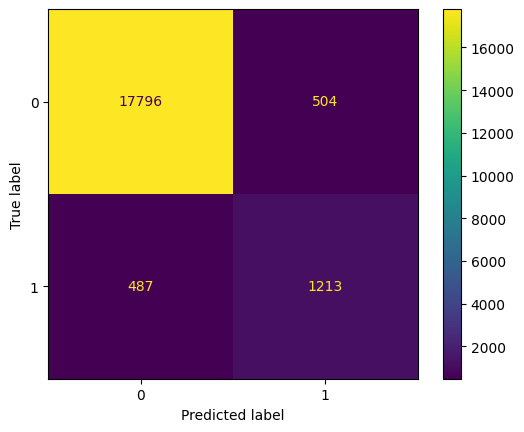

In [14]:
disp=ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.grid(False)
plt.show()

In [15]:
report=classification_report(y_test,y_pred1)
print(report)

              precision    recall  f1-score   support

           0       0.97      0.97      0.97     18300
           1       0.71      0.71      0.71      1700

    accuracy                           0.95     20000
   macro avg       0.84      0.84      0.84     20000
weighted avg       0.95      0.95      0.95     20000



In [16]:
roc_auc_score(y_test,y_pred)

0.9576547733847637

In [17]:
params={'n_estimators':1500,
                    'boosting_type': 'gbdt',
                    'objective': 'binary',
                    'metric': 'auc',
                    'subsample': 0.75,
                    'subsample_freq': 1,
                    'learning_rate': 0.01,
                    'feature_fraction': 0.75,
                    'num_leaves':32,
                    'max_depth': 10,
                    'lambda_l1': 1,
                    'lambda_l2': 1,
                    'early_stopping_rounds': 120,
                    # 'scale_pos_weight' : 2,
                    'verbose':1
                    }

In [18]:
train_data = lgb.Dataset(x_train, label=y_train)
valid_data = lgb.Dataset(x_test, label=y_test, reference=train_data)

In [19]:
lgbm1=lgb.train(params,train_data,valid_sets=[valid_data],valid_names=['valid'])

[LightGBM] [Info] Number of positive: 6800, number of negative: 73200
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010917 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.085000 -> initscore=-2.376273
[LightGBM] [Info] Start training from score -2.376273


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 120 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

In [20]:
y_pred=lgbm1.predict(x_test)

In [21]:
y_pred1=y_pred>0.5
cm1=confusion_matrix(y_test,y_pred1)
cm1

array([[18284,    16],
       [  542,  1158]])

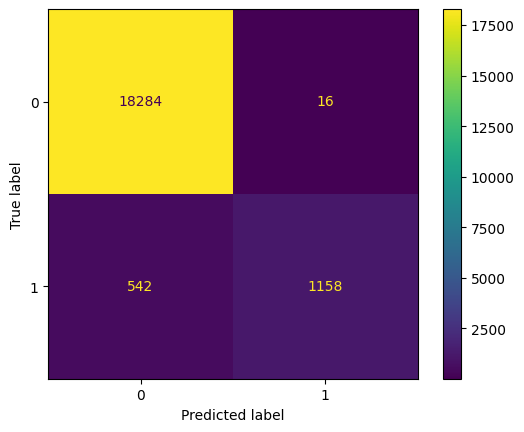

In [22]:
disp=ConfusionMatrixDisplay(confusion_matrix=cm1)
disp.plot()
plt.grid(False)
plt.show()

In [23]:
report=classification_report(y_test,y_pred1)
print(report)

              precision    recall  f1-score   support

           0       0.97      1.00      0.98     18300
           1       0.99      0.68      0.81      1700

    accuracy                           0.97     20000
   macro avg       0.98      0.84      0.90     20000
weighted avg       0.97      0.97      0.97     20000



In [24]:
roc_auc_score(y_test,y_pred)

0.9772120861459338

In [25]:
# STROKE PREDICTION STARTS

In [26]:
df1=pd.read_csv('stroke_data.csv')

In [27]:
df1.isnull().sum()

sex                  3
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [28]:
# encode_col=['gender','ever_married','work_type','Residence_type','smoking_status']
# for a in encode_col:
#   print(a)
#   le=LabelEncoder()
#   d1=le.fit_transform(df1[a])
#   df1[a]=d1


In [29]:
# x1=df1.drop(['id','stroke'],axis=1)
x1=df1.drop(['stroke'],axis=1)
y1=df1.stroke

In [30]:
x1_train,x1_test,y1_train,y1_test = train_test_split(x1,y1,test_size=0.2,stratify=y1,shuffle=True)

In [31]:
mm=MinMaxScaler(feature_range=(0,1))
x1_train=mm.fit_transform(x1_train)
x1_test=mm.transform(x1_test)

In [32]:
params={'n_estimators':1500,
                    'boosting_type': 'gbdt',
                    'objective': 'binary',
                    'metric': 'auc',
                    'subsample': 0.75,
                    'subsample_freq': 1,
                    'learning_rate': 0.01,
                    'feature_fraction': 0.75,
                    'num_leaves':32,
                    'max_depth': 10,
                    'lambda_l1': 1,
                    'lambda_l2': 1,
                    'early_stopping_rounds': 120,
                    # 'scale_pos_weight' : 2,
                    'verbose':1
                    }

In [33]:
train1_data = lgb.Dataset(x1_train, label=y1_train)
valid1_data = lgb.Dataset(x1_test, label=y1_test, reference=train1_data)

In [34]:
lgbm=lgb.train(params,train1_data,valid_sets=[valid1_data],valid_names=['valid'])

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 16368, number of negative: 16360
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002158 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 627
[LightGBM] [Info] Number of data points in the train set: 32728, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500122 -> initscore=0.000489
[LightGBM] [Info] Start training from score 0.000489
Training until validation scores don't improve for 120 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

In [35]:
y1_pred=lgbm.predict(x1_test)
y1_pred1=y1_pred>0.5

In [36]:
cm2=confusion_matrix(y1_test,y1_pred1)
cm2

array([[3976,  114],
       [   0, 4092]])

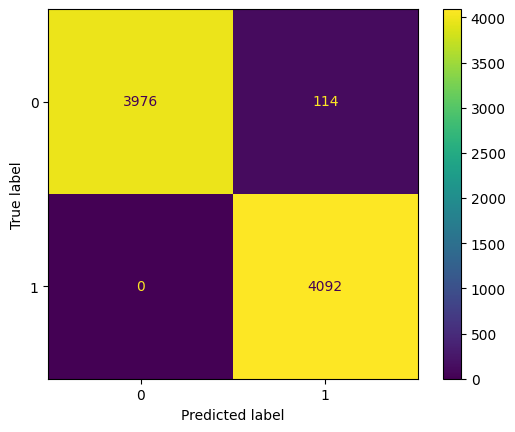

In [37]:
disp=ConfusionMatrixDisplay(confusion_matrix=cm2)
disp.plot()
plt.grid(False)
plt.show()

In [38]:
report=classification_report(y1_test,y1_pred1)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.97      0.99      4090
           1       0.97      1.00      0.99      4092

    accuracy                           0.99      8182
   macro avg       0.99      0.99      0.99      8182
weighted avg       0.99      0.99      0.99      8182



In [39]:
roc_auc_score(y1_test,y1_pred)


0.9992077092400462

In [40]:
ann1=tf.keras.models.Sequential()
ann1.add(tf.keras.layers.Dense(units=64,input_dim=x1_train.shape[1],activation='relu'))
ann1.add(tf.keras.layers.Dense(units=128,activation='relu'))
ann1.add(tf.keras.layers.Dense(units=64,activation='relu'))
ann1.add(tf.keras.layers.Dense(units=196,activation='relu'))
ann1.add(tf.keras.layers.BatchNormalization())
ann1.add(tf.keras.layers.Dense(units=32,activation='relu'))
ann1.add(tf.keras.layers.Dense(units=1,activation='sigmoid'))  #output layer
ann1.compile(optimizer=Adam(learning_rate=0.05),loss='binary_crossentropy',metrics=['accuracy'])

In [41]:
prediction=ann1.fit(x1_train,y1_train,batch_size=64,epochs=30,validation_data=(x1_test,y1_test))

Epoch 1/30
512/512 [==============================] - 5s 5ms/step - loss: nan - accuracy: 0.5842 - val_loss: nan - val_accuracy: 0.4999
Epoch 2/30
512/512 [==============================] - 2s 4ms/step - loss: nan - accuracy: 0.4999 - val_loss: nan - val_accuracy: 0.4999
Epoch 3/30
512/512 [==============================] - 2s 4ms/step - loss: nan - accuracy: 0.4999 - val_loss: nan - val_accuracy: 0.4999
Epoch 4/30
512/512 [==============================] - 2s 5ms/step - loss: nan - accuracy: 0.4999 - val_loss: nan - val_accuracy: 0.4999
Epoch 5/30
512/512 [==============================] - 4s 8ms/step - loss: nan - accuracy: 0.4999 - val_loss: nan - val_accuracy: 0.4999
Epoch 6/30
512/512 [==============================] - 2s 4ms/step - loss: nan - accuracy: 0.4999 - val_loss: nan - val_accuracy: 0.4999
Epoch 7/30
512/512 [==============================] - 2s 5ms/step - loss: nan - accuracy: 0.4999 - val_loss: nan - val_accuracy: 0.4999
Epoch 8/30
512/512 [============================

In [42]:
y1_pred=ann1.predict(x1_test)
y1_pred1=y1_pred>0.5

256/256 [==============================] - 1s 2ms/step


In [43]:
cm3=confusion_matrix(y1_test,y1_pred1)
cm3

array([[4090,    0],
       [4092,    0]])

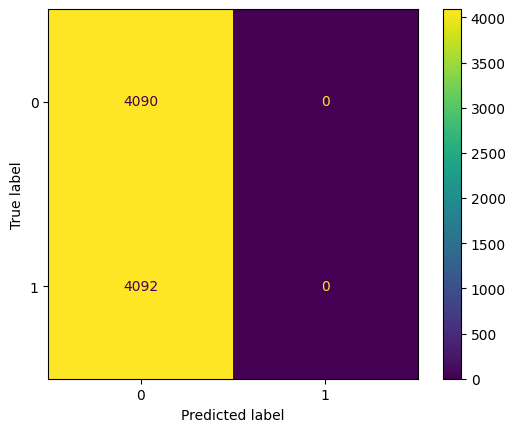

In [44]:
disp=ConfusionMatrixDisplay(confusion_matrix=cm3)
disp.plot()
plt.grid(False)
plt.show()

In [45]:
report=classification_report(y1_test,y1_pred1)
print(report)

              precision    recall  f1-score   support

           0       0.50      1.00      0.67      4090
           1       0.00      0.00      0.00      4092

    accuracy                           0.50      8182
   macro avg       0.25      0.50      0.33      8182
weighted avg       0.25      0.50      0.33      8182



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
